In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import weights
import json
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [65]:
#[delta_x, delta_y, hold_weight] IN ->
#[delta_x, delta_y] <- OUT

moves_dataset = []
moves_labels = []
hold_weights = weights.get_weights()

climb_data = {}
with open("../data/climbs.json", 'r') as file:
  climb_data = json.load(file)

In [66]:
for climb in climb_data:
    for i in range(1, len(climb['placements'])-1):
        next = climb['placements'][i+1]
        curr = climb['placements'][i]
        prev = climb['placements'][i-1]
        
        moves_dataset.append([
            climb['difficulty'],
            curr['x'] - prev['x'],
            curr['y'] - prev['y'],
            hold_weights[curr['x'], curr['y']-1]
        ])
        moves_labels.append([
            next['x'] - curr['x'],
            next['y'] - curr['y']
        ])

In [67]:
dataloader_tmp = []
for i in range(len(moves_dataset)): 
    dataloader_tmp.append((torch.tensor(moves_dataset[i], dtype=torch.float32), torch.tensor(moves_labels[i], dtype=torch.float32)))
dataloader = DataLoader(dataloader_tmp, batch_size=32, shuffle=True)

Epoch [1/2], Loss: 23.5416
Epoch [2/2], Loss: 99.3977


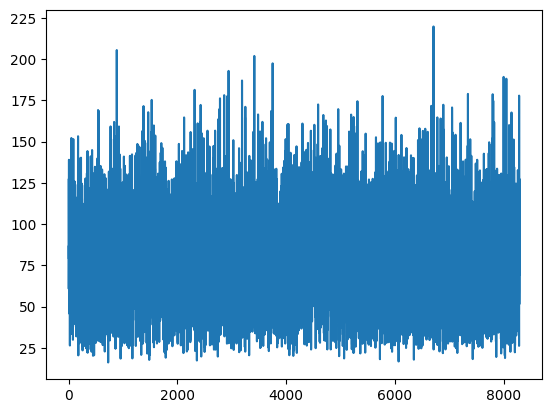

In [69]:

# Define the neural network architecture
class HoldPredictor(nn.Module):
    def __init__(self):
        super(HoldPredictor, self).__init__()
        # Define layers: 
        # - input layer: input_size to hidden_size
        # - hidden layer: hidden_size to hidden_size (optional, can add more layers)
        # - output layer: hidden_size to output_size
        input_size = 4
        hidden_size = 4
        output_size = 2
        
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()  # ReLU activation
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)  # Input to first hidden layer
        x = self.relu(x)  # Apply ReLU activation
        # x = self.fc2(x)  # Output from second layer
        # x = self.relu2(x)
        x = self.fc3(x)
        return x

# Instantiate the model
model = HoldPredictor()

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss (for regression)
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

# Example training loop
num_epochs = 2
losses = []
model.train()
for epoch in range(num_epochs):
    # Example random data (batch of inputs)

    for inputs, labels in dataloader:

        # Zero gradients from previous step
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model.forward(inputs)
    
        # Compute the loss
        loss = criterion(outputs, labels)
    
        # Backward pass (gradient computation)
        loss.backward()

        losses.append(loss.item())
    
        # Update the weights
        optimizer.step()
    
        # Print the loss every 100 epochs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'model.pth')

plt.plot(losses)
plt.show()
